## Dividing cells

In [1]:
#import library
%matplotlib inline
from libsbml import readSBML
from cobra import io,flux_analysis
from cobra.core import Reaction,Metabolite
from IPython import display
import time

##### Modelling

In [3]:
#import sbml file
dividing_model = io.sbml.create_cobra_model_from_sbml_file("Models/PlantCoreMetabolism_v1_2_3.xml")

#only glucose as nutrient
dividing_model.reactions.get_by_id("GLC_tx").upper_bound = 1000
dividing_model.reactions.get_by_id("GLC_tx").lower_bound = 0
dividing_model.reactions.get_by_id("Sucrose_tx").upper_bound = 0
dividing_model.reactions.get_by_id("Photon_tx").upper_bound = 0

#Setting up maintenance
met=Metabolite("ATPNAPDH_maintenance_constraint")
dividing_model.reactions.get_by_id("ATPase_tx").add_metabolites({met:-1})
dividing_model.reactions.get_by_id("NADPHoxc_tx").add_metabolites({met:3})
dividing_model.reactions.get_by_id("NADPHoxp_tx").add_metabolites({met:3})
dividing_model.reactions.get_by_id("NADPHoxm_tx").add_metabolites({met:3})
dividing_model.reactions.get_by_id("ATPase_tx").lower_bound = 0
dividing_model.reactions.get_by_id("ATPase_tx").upper_bound = 0


#Create a Protein_b metabolites
rxn = dividing_model.reactions.get_by_id("Biomass_tx")
for met in ["Ca_b","K_b","Mg_b"]:
    met = dividing_model.metabolites.get_by_id(met)
    coeff = rxn.metabolites.get(met)
    rxn.add_metabolites({met:-1*coeff})
met = Metabolite("Protein_b",name="Protein_biomass")
formula_dict = rxn.check_mass_balance()
met.formula = "".join([atom+str(formula_dict[atom]*-1) for atom in formula_dict.keys() if atom != "charge"])
met.charge = formula_dict["charge"]*-1
rxn.add_metabolites({met:1})


#### Data processed from Rontein et al 2002

In [4]:
import pandas as pd
data={"sSUCROSE_b":0.00023384868704189686,"sCIT_b":8.668117044773994e-05,"sMAL_b":2.9579139027799716e-05,
      "FRU":0.0003876698255039685,"GLC":0.0006427015896873639}
temp1 = data.keys()
temp2 = list()
for t in temp1:
    temp2.append(data.get(t))
df = pd.DataFrame(data={"mets":temp1,"amount":temp2})
df = df[['mets', 'amount']]
df

,mets,amount
0,sCIT_b,0.000087
1,sSUCROSE_b,0.000234
2,GLC,0.000643
3,FRU,0.000388
4,sMAL_b,0.000030


In [5]:

#Addd dividing biomass
rxn = Reaction("Biomass_dividing")
rxn.add_metabolites({dividing_model.metabolites.get_by_id("Cellulose_b"):-1*0.004167174993906135})
rxn.add_metabolites({dividing_model.metabolites.get_by_id("L_PHOSPHATIDATE_p"):-1*0.0002663702867671667})
rxn.add_metabolites({dividing_model.metabolites.get_by_id("Protein_b"):-1*0.0003168809295998026})
rxn.add_metabolites({dividing_model.metabolites.get_by_id("Starch_b"):-1*0.0011297601948076414})
dividing_model.add_reaction(rxn)

soluteTranslate={"sSUCROSE_b":"SUCROSE","sCIT_b":"CIT","sMAL_b":"MAL","sSUC_b":"SUC","sFUM_b":"FUM",
                 "sASP_b":"L_ASPARTATE","sGLU_b":"GLT","sGLN_b":"GLN","sGABA_b":"4_AMINO_BUTYRATE",
                 "sALA_b":"L_ALPHA_ALANINE"}

for met2 in df["mets"]:
    if met2 in soluteTranslate.keys():
        met = soluteTranslate[met2]
    else:
        met = met2
    METB = Metabolite(met+"_b")
    if met=="HIS":
        METV = dividing_model.metabolites.get_by_id(met+"_v")
        rxn = Reaction(met+"_v_biomass")
        rxn.add_metabolites({METV:-1,METB:1})
        dividing_model.add_reaction(rxn)
    elif met=="MAL":
        METV = dividing_model.metabolites.get_by_id(met+"_v")
        aMETV = dividing_model.metabolites.get_by_id("a"+met+"_v")
        charge = (METV.charge*0.7)+(aMETV.charge*0.3)
        rxn = Reaction(met+"_v_biomass")
        rxn.add_metabolites({METV:-0.7,aMETV:-0.3,METB:1})
        dividing_model.add_reaction(rxn)
    elif met=="CIT":
        METV = dividing_model.metabolites.get_by_id(met+"_v")
        aMETV = dividing_model.metabolites.get_by_id("a"+met+"_v")
        charge = (METV.charge*0.5)+(aMETV.charge*0.5)
        rxn = Reaction(met+"_v_biomass")
        rxn.add_metabolites({METV:-0.5,aMETV:-0.5,METB:1})
        dividing_model.add_reaction(rxn)
    elif met=="FUM":
        METV = dividing_model.metabolites.get_by_id(met+"_v")
        aMETV = dividing_model.metabolites.get_by_id("a"+met+"_v")
        charge = (METV.charge*0.92)+(aMETV.charge*0.08)
        rxn = Reaction(met+"_v_biomass")
        rxn.add_metabolites({METV:-0.92,aMETV:-0.08,METB:1})
        dividing_model.add_reaction(rxn)
    elif met=="SUC":
        print("Skipping SUC_v")
    else:
        METV = dividing_model.metabolites.get_by_id(met+"_v")
        rxn = Reaction(met+"_v_biomass")
        rxn.add_metabolites({METV:-1,METB:1})
        dividing_model.add_reaction(rxn)
    ##############
    METC = dividing_model.metabolites.get_by_id(met+"_c")
    rxn = Reaction(met+"_c_biomass")
    rxn.add_metabolites({METC:-1,METB:1})
    dividing_model.add_reaction(rxn)
    
    rxn = dividing_model.reactions.get_by_id("Biomass_dividing")
    rxn.add_metabolites({METB:-1*0.14*float(df["amount"][df["mets"]==met2])})
rxn = dividing_model.reactions.get_by_id("Biomass_dividing")
rxn.lower_bound = 0
rxn.upper_bound = 1000

dividing_model.reactions.get_by_id("Biomass_dividing").objective_coefficient=1
#dividing_model.reactions.get_by_id("GLC_tx").objective_coefficient=-1

solution = flux_analysis.parsimonious.pfba(dividing_model)
print("Maximal glucose uptake rate =")
print(dividing_model.reactions.get_by_id("GLC_tx").x)


Maximal glucose uptake rate =
9.41386175027


In [6]:
### set max growth rate based on Rontein 2002 
#max growth rate = 2 mg/ml = 2 g/L
backup_dividing = dividing_model.copy()
rxn = dividing_model.reactions.get_by_id("Biomass_dividing")
formula_dict = rxn.check_mass_balance()
Biomass_MW2 = 0
for met in rxn.metabolites:
    Biomass_MW2=Biomass_MW2+(rxn.metabolites.get(met)*met.formula_weight*-1)
#max growth rate = 2 mg/ml = 2 g/L
rxn.upper_bound = 2.009/Biomass_MW2
rxn.lower_bound = 2.009/Biomass_MW2
solution = flux_analysis.parsimonious.pfba(dividing_model)
print("Glucose uptake rate =")
print(dividing_model.reactions.get_by_id("GLC_tx").x)


Glucose uptake rate =
0.0163391158878


cobra/core/metabolite.py:103 UserWarning: 17.2020450391 is not an integer (in formula C17.2020450391H25.9492553613O5.7497158698N4.9536245179S0.1420323181)
cobra/core/metabolite.py:103 UserWarning: 25.9492553613 is not an integer (in formula C17.2020450391H25.9492553613O5.7497158698N4.9536245179S0.1420323181)
cobra/core/metabolite.py:103 UserWarning: 5.7497158698 is not an integer (in formula C17.2020450391H25.9492553613O5.7497158698N4.9536245179S0.1420323181)
cobra/core/metabolite.py:103 UserWarning: 4.9536245179 is not an integer (in formula C17.2020450391H25.9492553613O5.7497158698N4.9536245179S0.1420323181)
cobra/core/metabolite.py:103 UserWarning: 0.1420323181 is not an integer (in formula C17.2020450391H25.9492553613O5.7497158698N4.9536245179S0.1420323181)


In [7]:
print("Glucose uptake rate =")
print(dividing_model.reactions.get_by_id("GLC_tx").x*dividing_model.metabolites.get_by_id("GLC_c").formula_weight)

Glucose uptake rate =
2.94358780119


##### Estimation of maintenance cell model

Maintenance was estimated by increasing ATPase flux until Carbon conversion efficiency (CCE) = 70%

In [11]:
Fraction = 0
i = 0
while Fraction < 0.3:
    i=i+0.001
    tempModel = dividing_model.copy()
    tempModel.reactions.get_by_id("ATPase_tx").lower_bound = i
    tempModel.reactions.get_by_id("ATPase_tx").upper_bound = i
    solution = flux_analysis.parsimonious.pfba(tempModel)
    Fraction = -1*solution.fluxes.get("CO2_tx")/(6*solution.fluxes.get("GLC_tx"))
    print "NGAM ATPase flux ="+str(i)
    print "(1 - CCE) ="+str(Fraction)
    print "---------------------------"

print "Assumed maintenance cost, ATP ="
print tempModel.reactions.get_by_id("ATPase_tx").x

NGAM ATPase flux =0.001
(1 - CCE) =0.15465291192209596
---------------------------
NGAM ATPase flux =0.002
(1 - CCE) =0.15738711117061668
---------------------------
NGAM ATPase flux =0.003
(1 - CCE) =0.16010368039795336
---------------------------
NGAM ATPase flux =0.004
(1 - CCE) =0.1628027895727708
---------------------------
NGAM ATPase flux =0.005
(1 - CCE) =0.1654846064858721
---------------------------
NGAM ATPase flux =0.006
(1 - CCE) =0.16814929678497031
---------------------------
NGAM ATPase flux =0.007
(1 - CCE) =0.17079702400879326
---------------------------
NGAM ATPase flux =0.008
(1 - CCE) =0.1735269998808617
---------------------------
NGAM ATPase flux =0.009
(1 - CCE) =0.17624507780550344
---------------------------
NGAM ATPase flux =0.01
(1 - CCE) =0.17894533607964466
---------------------------
NGAM ATPase flux =0.011
(1 - CCE) =0.1816279493685055
---------------------------
NGAM ATPase flux =0.012
(1 - CCE) =0.184293090062022
---------------------------
NGAM ATPase

Constraining maintenance cost

In [12]:
backup_dividing2 = dividing_model.copy()
dividing_model.reactions.get_by_id("ATPase_tx").lower_bound = 0.062
dividing_model.reactions.get_by_id("ATPase_tx").upper_bound = 0.062
solution = flux_analysis.parsimonious.pfba(dividing_model)

#### Introduce osmotic cosntraints to force vacuolar accumulation

In [13]:
from studyFunctions import estimateVcell
import math

#Beauvoit et al data
T = 5
Vv = 0.853*(1-(math.e**((-2293-(T*24*60))/10633)))
Vc = (0.933 - Vv)/1.13

In [14]:
df

,mets,amount
0,sCIT_b,0.000087
1,sSUCROSE_b,0.000234
2,GLC,0.000643
3,FRU,0.000388
4,sMAL_b,0.000030


In [15]:
dividing_model2 = dividing_model.copy()
#Setting up osmotic constraints
#solutes=["SUCROSE","MAL","NITRATE","AMMONIUM","CIT","GLN","ASN","SER","GLY","THR","L_ALPHA_ALANINE","4_AMINO_BUTYRATE","VAL","ILE","PHE","LEU","LYS","ARG","L_ASPARTATE","GLT","HIS","MET","PRO","TRP","TYR","CYS","GLC","FRU","FUM","MGII","KI","CAII"]
#solutes=["SUCROSE","MAL","CIT","GLN","ASN","SER","GLY","THR","L_ALPHA_ALANINE","4_AMINO_BUTYRATE","VAL","ILE","PHE","LEU","LYS","ARG","L_ASPARTATE","GLT","HIS","MET","PRO","TRP","TYR","CYS","GLC","FRU","FUM"]
#solutes=["SUCROSE","GLC","FRU"]
soluteTranslate={"sSUCROSE_b":"SUCROSE","sCIT_b":"CIT","sMAL_b":"MAL","sSUC_b":"SUC","sFUM_b":"FUM","sASP_b":"L_ASPARTATE","sGLU_b":"GLT","sGLN_b":"GLN","sGABA_b":"4_AMINO_BUTYRATE","sALA_b":"L_ALPHA_ALANINE"}
VO = Metabolite("VO",name="vacuolar osmolytes")
VC = Metabolite("VC",name="vacuolar charge")
CO = Metabolite("CO",name="cytosolic osmolytes")
CC = Metabolite("CC",name="cytosolic charge")


for met2 in df["mets"]:
    if met2 in soluteTranslate.keys():
        met = soluteTranslate[met2]
    else:
        met = met2
    if met=="HIS":
        METV = dividing_model.metabolites.get_by_id(met+"_v")
        rxn = dividing_model2.reactions.get_by_id(met+"_v_biomass")
        rxn.add_metabolites({VC:METV.charge,VO:1})
    elif met=="MAL":
        METV = dividing_model.metabolites.get_by_id(met+"_v")
        aMETV = dividing_model.metabolites.get_by_id("a"+met+"_v")
        charge = (METV.charge*0.7)+(aMETV.charge*0.3)
        rxn = dividing_model2.reactions.get_by_id(met+"_v_biomass")
        rxn.add_metabolites({VC:charge,VO:1})
    elif met=="CIT":
        METV = dividing_model.metabolites.get_by_id(met+"_v")
        aMETV = dividing_model.metabolites.get_by_id("a"+met+"_v")
        charge = (METV.charge*0.5)+(aMETV.charge*0.5)
        rxn = dividing_model2.reactions.get_by_id(met+"_v_biomass")
        rxn.add_metabolites({VC:charge,VO:1})
    elif met=="FUM":
        METV = dividing_model.metabolites.get_by_id(met+"_v")
        aMETV = dividing_model.metabolites.get_by_id("a"+met+"_v")
        charge = (METV.charge*0.92)+(aMETV.charge*0.08)
        rxn = dividing_model2.reactions.get_by_id(met+"_v_biomass")
        rxn.add_metabolites({VC:charge,VO:1})
    elif met=="SUC":
        print("Skipping SUC_v")
    else:
        METV = dividing_model.metabolites.get_by_id(met+"_v")
        rxn = dividing_model2.reactions.get_by_id(met+"_v_biomass")
        rxn.add_metabolites({VC:METV.charge,VO:1})
    ##############
    METC = dividing_model.metabolites.get_by_id(met+"_c")
    rxn = dividing_model2.reactions.get_by_id(met+"_c_biomass")
    rxn.add_metabolites({CC:METC.charge,CO:1})
    

for met in ["NITRATE","AMMONIUM","MGII","KI","CAII"]:
    METB = Metabolite(met+"_b")
    METV = dividing_model2.metabolites.get_by_id(met+"_v")
    rxn = Reaction(met+"_v_biomass")
    rxn.add_metabolites({METV:-1,VC:METV.charge,VO:1,METB:1})
    dividing_model2.add_reaction(rxn)
    
    METC = dividing_model2.metabolites.get_by_id(met+"_c")
    rxn = Reaction(met+"_c_biomass")
    rxn.add_metabolites({METC:-1,CC:METC.charge,CO:1,METB:1})
    dividing_model2.add_reaction(rxn)
    
    rxn = Reaction(met+"_b_biomass")
    rxn.add_metabolites({METB:-1})
    dividing_model2.add_reaction(rxn)

rxn = Reaction("VacCytRatio")
WO = Metabolite("TotalSolute")
rxn.add_metabolites({CO:-1,VO:-1*(Vv/Vc),WO:1+(Vv/Vc)})
rxn.lower_bound = 0
rxn.upper_bound = 1000
dividing_model2.add_reaction(rxn)

rxn = Reaction("TotalSoluteConstraint")
rxn.add_metabolites({WO:-1})
rxn.lower_bound = 0
rxn.upper_bound = 1000
dividing_model2.add_reaction(rxn)

In [16]:
dividing_model2.reactions.get_by_id("ATPase_tx").lower_bound = 0.062
dividing_model2.reactions.get_by_id("ATPase_tx").upper_bound = 0.062
solution = flux_analysis.parsimonious.pfba(dividing_model2)
print("Glucose uptake rate =")
print("\t= "+str(dividing_model2.reactions.get_by_id("GLC_tx").x)+" mmol/mL/day")
print("\t= "+str(dividing_model2.reactions.get_by_id("GLC_tx").x*dividing_model2.metabolites.get_by_id("GLC_c").formula_weight)+" mg/mL/day")



Glucose uptake rate =
	= 0.0198157273058 mmol/mL/day
	= 3.56991979062 mg/mL/day


In [17]:
from studyFunctions import writeSolutionFluxesToFile

writeSolutionFluxesToFile(solution,"DividingFluxes.csv",dividing_model2)

#### Data to generate flux map

In [18]:
mets = ["GLC_c","GLC_p","GLC_6_P_c","GLC_6_P_p","Cellulose_b","SUCROSE_c","SUCROSE_v","FRU_c",
        "FRU_v","FRUCTOSE_6P_c","GLYCEROL_3P_c","GAP_c","GAP_p","G3P_c","G3P_p","PHOSPHO_ENOL_PYRUVATE_c",
        "PHOSPHO_ENOL_PYRUVATE_p","PYRUVATE_c","PYRUVATE_p","Protein_b"]
for met in mets:
    met = dividing_model2.metabolites.get_by_id(met)
    R = dividing_model2.reactions.get_by_id("GLC_ec")
    Cnum_std = dividing_model2.metabolites.get_by_id("GLC_c").elements["C"]
    Cnum = met.elements["C"]
    print "-----"
    print met.id
    for rxn in met.reactions:
        if round(rxn.x,5)==0:
            continue
        print rxn.id+"\t"+str(((rxn.x*rxn.metabolites.get(met)*Cnum)/(R.x*Cnum_std))*12)

-----
GLC_c
GLC_ec	12.0
GLC_PROTON_rev_vc	-0.0415235800268
GLC_c_biomass	-0.0530499012388
GLUCOKIN_RXN_c	-11.9054265187
-----
GLC_p
-----
GLC_6_P_c
GLUCOKIN_RXN_c	11.9054265187
GLU6PDEHYDROG_RXN_c	-3.06070463804
PGLUCISOM_RXN_c	-4.4303151637
PHOSPHOGLUCMUT_RXN_c	-4.414406717
-----
GLC_6_P_p
PGLUCISOM_RXN_p	3.50003365231
GLU6PDEHYDROG_RXN_p	-2.31257571435
PHOSPHOGLUCMUT_RXN_p	-1.18745793796
-----
Cellulose_b
Cellulose_biomass	4.37999590368
Biomass_dividing	-4.37999590368
-----
SUCROSE_c
SUCROSE_PHOSPHATASE_RXN_c	0.182912786729
SUCROSE_SYNTHASE_RXN_c	-0.11409116009
SUCROSE_c_biomass	-0.0688216266392
-----
SUCROSE_v
-----
FRU_c
SUCROSE_SYNTHASE_RXN_c	0.0570455800449
FRU_PROTON_rev_vc	-0.0570455800449
-----
FRU_v
FRU_v_biomass	-0.0570455800449
FRU_PROTON_rev_vc	0.0570455800449
-----
FRUCTOSE_6P_c
SUCROSE_PHOSPHATE_SYNTHASE_RXN_c	-0.0914563933645
2_PERIOD_7_PERIOD_1_PERIOD_90_RXN_c	-4.33885877034
PGLUCISOM_RXN_c	4.4303151637
-----
GLYCEROL_3P_c
GLYCEROL_3P_pc	-0.139987013577
GLYC3PDEHYDROGB

In [19]:
R = dividing_model2.reactions.get_by_id("GLC_ec")
Cnum_std = dividing_model2.metabolites.get_by_id("GLC_c").elements["C"]
for rxn in dividing_model2.reactions.query("_c_biomass"):    
    met = list(set(rxn.products) - set([dividing_model2.metabolites.get_by_id("CC"),dividing_model2.metabolites.get_by_id("VC"),dividing_model2.metabolites.get_by_id("VO"),dividing_model2.metabolites.get_by_id("CO")]))[0]
    
    if "C" in met.elements.keys():
        Cnum = met.elements["C"]
    else:
        formula_dict = rxn.check_mass_balance()
        formula = "".join([atom+str(formula_dict[atom]*-1) for atom in formula_dict.keys() if atom != "charge"])
        if "C" in formula and "Ca" not in formula:
            met.formula= formula
            Cnum = met.elements["C"]
        else:
            Cnum = 1
    print "-----"
    print met.id
    for rxn in met.reactions:
        if round(rxn.x,5)==0:
            continue
        print rxn.id+"\t"+str(((rxn.x*rxn.metabolites.get(met)*Cnum)/(R.x*Cnum_std))*12)

-----
CIT_b
CIT_v_biomass	0.0127551264552
Biomass_dividing	-0.0127551264552
-----
SUCROSE_b
Biomass_dividing	-0.0688216266392
SUCROSE_c_biomass	0.0688216266392
-----
GLC_b
GLC_v_biomass	0.0415235800268
Biomass_dividing	-0.0945734812656
GLC_c_biomass	0.0530499012388
-----
FRU_b
FRU_v_biomass	0.0570455800449
Biomass_dividing	-0.0570455800449
-----
MAL_b
MAL_v_biomass	0.00290171176959
Biomass_dividing	-0.00290171176959
-----
NITRATE_b
-----
AMMONIUM_b
-----
MGII_b
MGII_v_biomass	0.00327393176254
MGII_b_biomass	-0.00327393176254
-----
KI_b
-----
CAII_b


### Estimating ATP cost of protein, lipid, cellulose and starch biosynthesis

In [20]:
dividing_model3 = dividing_model2.copy()
dividing_model3.reactions.get_by_id("Biomass_dividing").lower_bound = 0
dividing_model3.reactions.get_by_id("Biomass_dividing").upper_bound = 0
rxn =Reaction("tempSINK")
rxn.add_metabolites({dividing_model3.metabolites.get_by_id("Protein_b"):-1})
rxn.lower_bound = dividing_model2.reactions.get_by_id("Biomass_tx").x
rxn.upper_bound = dividing_model2.reactions.get_by_id("Biomass_tx").x
dividing_model3.add_reaction(rxn)
dividing_model3.reactions.get_by_id("ATPase_tx").add_metabolites({dividing_model3.metabolites.get_by_id("ATPNAPDH_maintenance_constraint"):1})
dividing_model3.reactions.get_by_id("ATPase_tx").lower_bound = -1000
dividing_model3.reactions.get_by_id("ATPase_tx").upper_bound = 1000
dividing_model3.reactions.get_by_id("Biomass_dividing").objective_coefficient = 0
dividing_model3.reactions.get_by_id("tempSINK").objective_coefficient = 1
temp_solution = flux_analysis.parsimonious.pfba(dividing_model3)
print("protein")
dividing_model3.reactions.get_by_id("ATPase_tx").x

protein


-0.019752436064982698

In [21]:
dividing_model3 = dividing_model2.copy()
dividing_model3.reactions.get_by_id("Biomass_dividing").lower_bound = 0
dividing_model3.reactions.get_by_id("Biomass_dividing").upper_bound = 0
rxn =Reaction("tempSINK")
rxn.add_metabolites({dividing_model3.metabolites.get_by_id("L_PHOSPHATIDATE_p"):-1})
rxn.lower_bound = dividing_model2.reactions.get_by_id("1_ACYLGLYCEROL_3_P_ACYLTRANSFER_RXN_p").x
rxn.upper_bound = dividing_model2.reactions.get_by_id("1_ACYLGLYCEROL_3_P_ACYLTRANSFER_RXN_p").x
dividing_model3.add_reaction(rxn)
dividing_model3.reactions.get_by_id("ATPase_tx").add_metabolites({dividing_model3.metabolites.get_by_id("ATPNAPDH_maintenance_constraint"):1})
dividing_model3.reactions.get_by_id("ATPase_tx").lower_bound = -1000
dividing_model3.reactions.get_by_id("ATPase_tx").upper_bound = 1000
dividing_model3.reactions.get_by_id("Biomass_dividing").objective_coefficient = 0
dividing_model3.reactions.get_by_id("tempSINK").objective_coefficient = 1
temp_solution = flux_analysis.parsimonious.pfba(dividing_model3)
print("lipid")
dividing_model3.reactions.get_by_id("ATPase_tx").x

lipid


-0.013522979376102771

In [22]:
dividing_model3 = dividing_model2.copy()
dividing_model3.reactions.get_by_id("Biomass_dividing").lower_bound = 0
dividing_model3.reactions.get_by_id("Biomass_dividing").upper_bound = 0
rxn =Reaction("tempSINK")
rxn.add_metabolites({dividing_model3.metabolites.get_by_id("Cellulose_b"):-1})
rxn.lower_bound = abs(dividing_model2.reactions.get_by_id("Cellulose_biomass").x)
rxn.upper_bound = abs(dividing_model2.reactions.get_by_id("Cellulose_biomass").x)
dividing_model3.add_reaction(rxn)
dividing_model3.reactions.get_by_id("ATPase_tx").add_metabolites({dividing_model3.metabolites.get_by_id("ATPNAPDH_maintenance_constraint"):1})
dividing_model3.reactions.get_by_id("ATPase_tx").lower_bound = -1000
dividing_model3.reactions.get_by_id("ATPase_tx").upper_bound = 1000
dividing_model3.reactions.get_by_id("Biomass_dividing").objective_coefficient = 0
dividing_model3.reactions.get_by_id("tempSINK").objective_coefficient = 1
temp_solution = flux_analysis.parsimonious.pfba(dividing_model3)
print("cellulose")
dividing_model3.reactions.get_by_id("ATPase_tx").x

cellulose


-0.021698201106989376

In [23]:
dividing_model3 = dividing_model2.copy()
dividing_model3.reactions.get_by_id("Biomass_dividing").lower_bound = 0
dividing_model3.reactions.get_by_id("Biomass_dividing").upper_bound = 0
rxn =Reaction("tempSINK")
rxn.add_metabolites({dividing_model3.metabolites.get_by_id("STARCH_p"):-1})
rxn.lower_bound = abs(dividing_model2.reactions.get_by_id("Starch_biomass").x)
rxn.upper_bound = abs(dividing_model2.reactions.get_by_id("Starch_biomass").x)
dividing_model3.add_reaction(rxn)
dividing_model3.reactions.get_by_id("ATPase_tx").add_metabolites({dividing_model3.metabolites.get_by_id("ATPNAPDH_maintenance_constraint"):1})
dividing_model3.reactions.get_by_id("ATPase_tx").lower_bound = -1000
dividing_model3.reactions.get_by_id("ATPase_tx").upper_bound = 1000
dividing_model3.reactions.get_by_id("Biomass_dividing").objective_coefficient = 0
dividing_model3.reactions.get_by_id("tempSINK").objective_coefficient = 1
temp_solution = flux_analysis.parsimonious.pfba(dividing_model3)
print("starch")
dividing_model3.reactions.get_by_id("ATPase_tx").x

starch


-0.005882585671457349

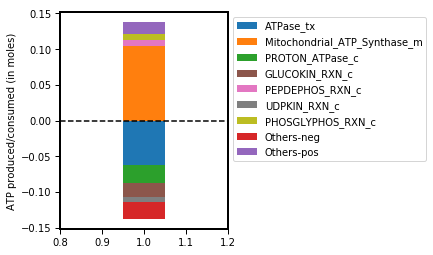

In [25]:
from studyFunctions import generateATPbudget

generateATPbudget(dividing_model2,solution.fluxes,outfile="ATP_budget_dividing.csv",
                  show_plot=True,percentage=False,day_or_night_tag="",save_plot_to="",colourDict={})

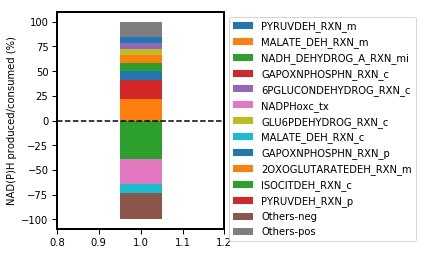

In [26]:
from studyFunctions import generateNADHNADPHbudget

generateNADHNADPHbudget(dividing_model2,solution.fluxes,outfile="NADPHbudget_dividing",
                        show_plot=True,percentage=True,day_or_night_tag="",save_plot_to="temp.png",colourDict={})

In [27]:
from studyFunctions import writeSolutionFluxesToFile

writeSolutionFluxesToFile(solution,"DividingFluxes",dividing_model2)

## Expanding cell - 2

In [28]:
#Estimate volume of cell wall in a cell
def estimateVcellwallSample(Vcell):
    #Vcell                           #unit = m3
    #cell wall thickness = 100 nm according to figure 19-68, https://www.ncbi.nlm.nih.gov/books/NBK26928/
    b=100*(10**-9)                   #unit = m
    y = (8*(b**3))+(6*(Vcell**(2.0/3))*b)-(12*(Vcell**(1.0/3))*(b**2))
    return y

#Esimate cellulose content
def celluloseLevels(Vcell,Ncell):
    p_cellulose = 1.54*(10**6)              # unit = g/m3
    x = estimateVcellwallSample(Vcell)      # unit = m3/cell
    y = x*p_cellulose                       # unit = g/cell
    z = (y/180.16)*(10**6)*Ncell            # unit = umol/culture
    return z

#Estimate cell membrane of a cell
def estimateVcellmembrane(Vcell):
    #Vcell                       #unit = m3
    #cell wall thickness = 100 nm according to figure 19-68, https://www.ncbi.nlm.nih.gov/books/NBK26928/
    b=100*(10**-9)	
    #cell membrane thickness = 10 nm according to https://hypertextbook.com/facts/2001/JenniferShloming.shtml (see Hine, Robert. "Membrane." The Facts on File Dictionary of Biology. 3rd ed. New York: Checkmark, 1999: 198.)
    #c = 10*(10**-9)				#unit = m
    #cell membrane thickness = 4 nm BioNumbers
    c = 4*(10**-9)				#unit = m
    y = (8*(c**3))+(6*(Vcell**(2.0/3))*c)-(24*(b**2)*c)-(12*(c**2)*((Vcell**(1.0/3))-(2*b)))-(24*(Vcell**(1.0/3))*b*c)	#unit = m3
    return y

#Esimate phospholipid content
def phospholipidLevels(Vcell,Ncells):
    #dipalmitoyl phosphatidate  density = 0.928*(10**6)
    p_PA = 0.928*(10**6)              # unit = g/m3
    mw_PA = 646.88                    # unit = g/mol
    x = estimateVcellmembrane(Vcell)  # unit = m3/cell
    y = x*p_PA                        # unit = g/cell
    z = (y/mw_PA)*(10**6)*Ncells*(100.0/11.75)      # unit = umol/culture
    return z


#Estimate total protein content
def estimateProteinContent(Vcell,Ncell,ProtConc):
    #Vcell                           # unit = m3
    Vcyt = Vcell*(50.0/100.0)        # unit = m3/cell
    Vcyt_total = Vcyt*Ncell          # unit = m3/culture
    y = ProtConc*Vcyt_total*(10**6)        # unit = umol/culture
    return y



In [29]:

import math

#Assuming cell number = 0.1 to 0.4 million
Ncells = 1.45*(10**9)

#Beauvoit et al data
Vcell1 = estimateVcell(26)
Vcell2 = estimateVcell(27)
T = 26.63
Vcell1 = ((0.02894333/(0.00760074+(math.e**(-0.18324543*T))))-0.03277816)*(10**-12) # units = m3
Vcell_dash = (0.005303727*(math.e**(-0.18324543*T)))/((0.00760074+(math.e**(-0.18324543*T)))**2)
Vv = 0.853*(1-(math.e**((-2293-(T*24*60))/10633)))
Vc = (0.933 - Vv)/1.13

Processing GLC...


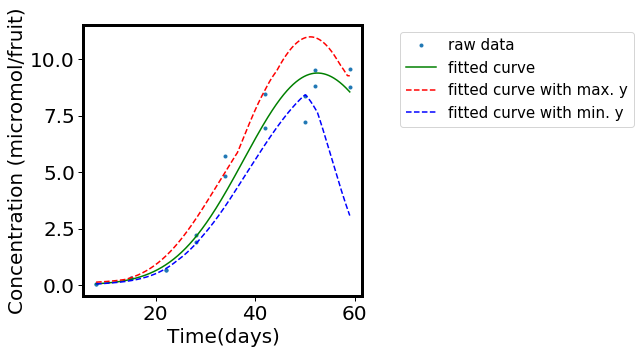

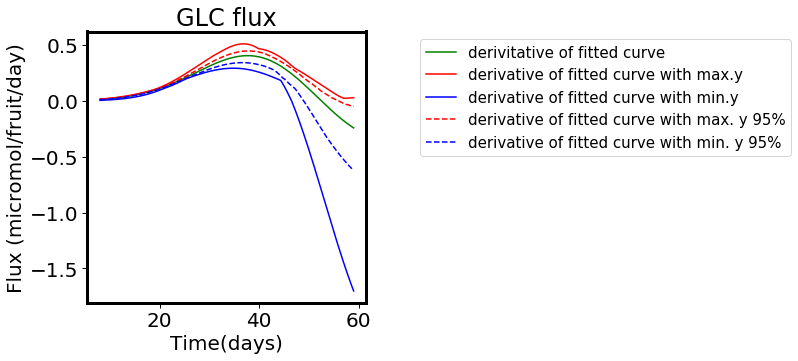

Processing FRU...


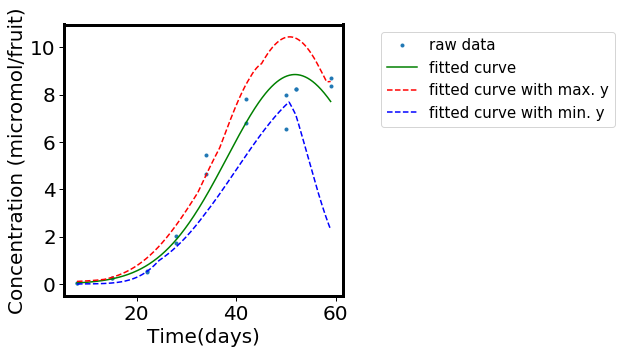

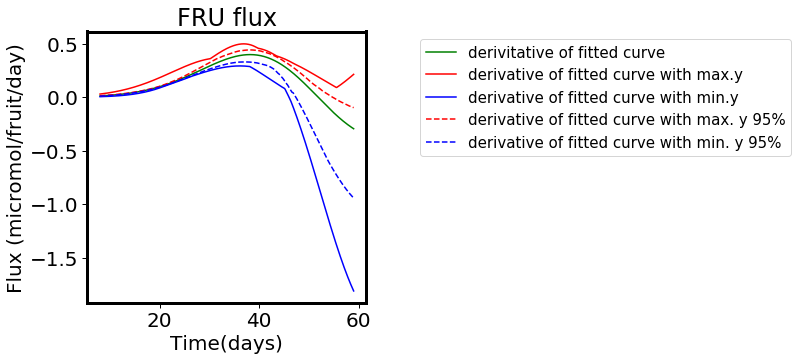

Processing SUC...


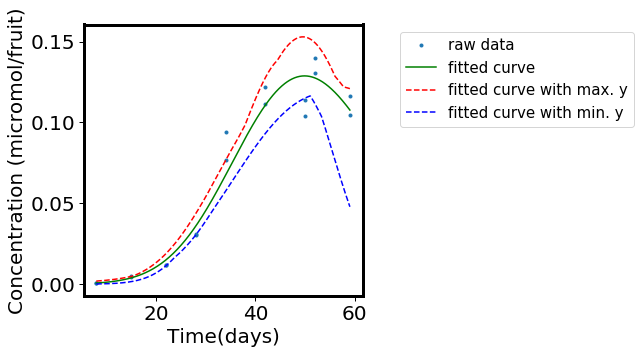

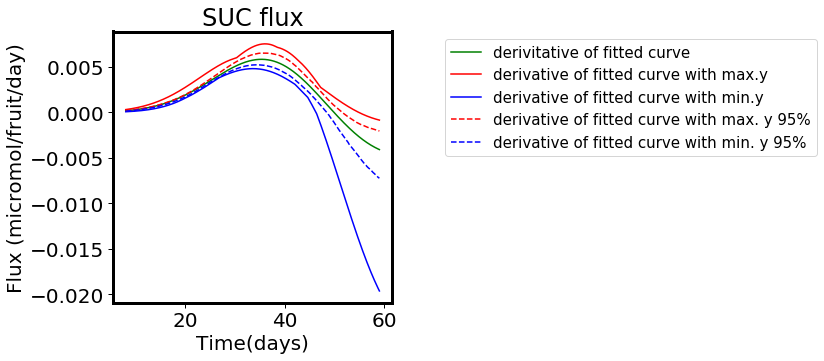

Processing MAL...


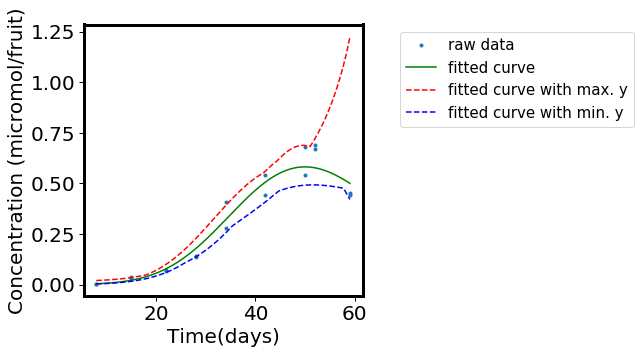

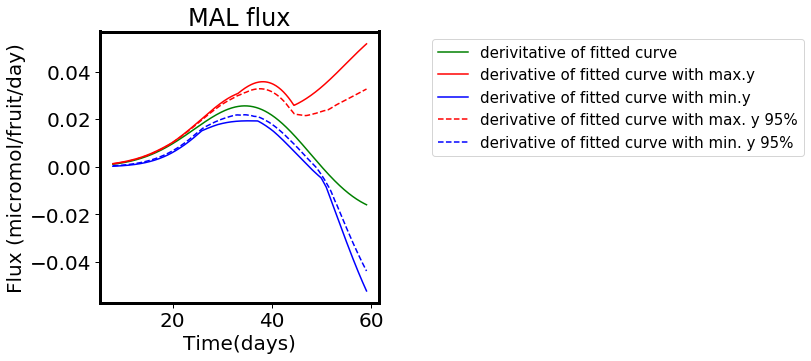

Processing CIT...


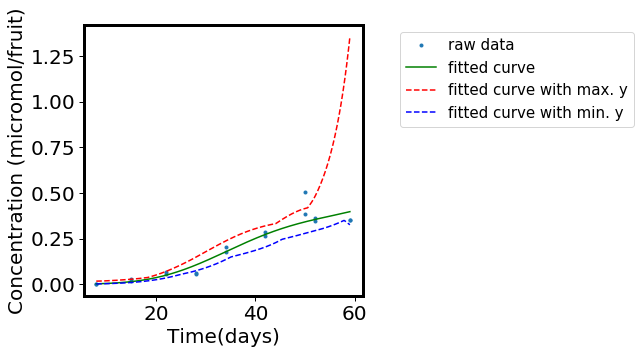

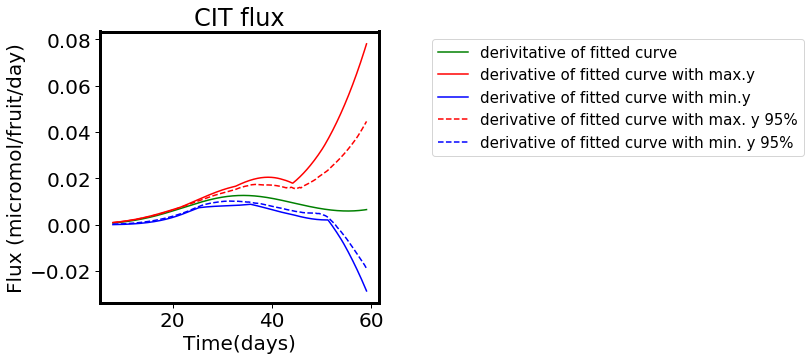

Processing L_ALPHA_ALANINE...


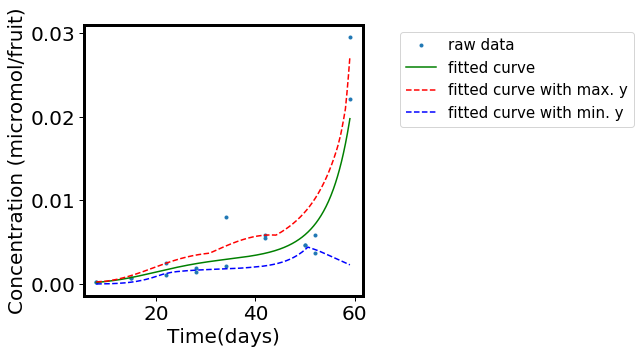

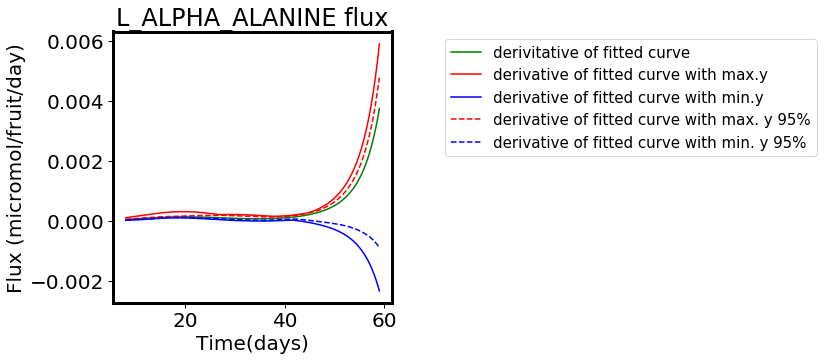

Processing ASN...


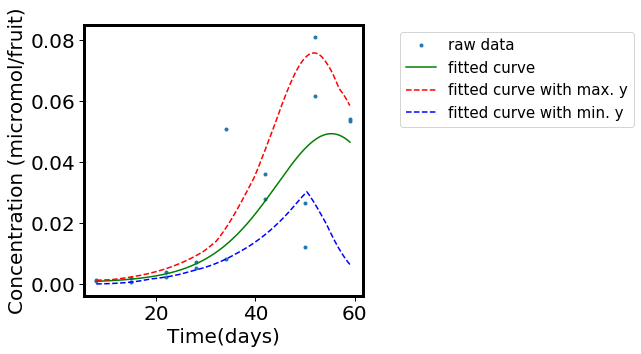

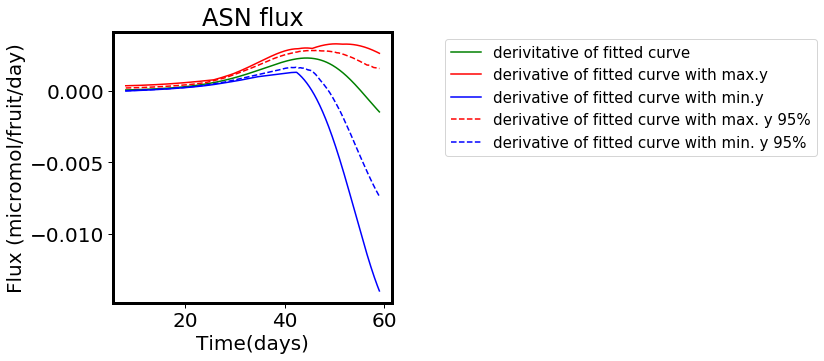

Processing L_ASPARTATE...


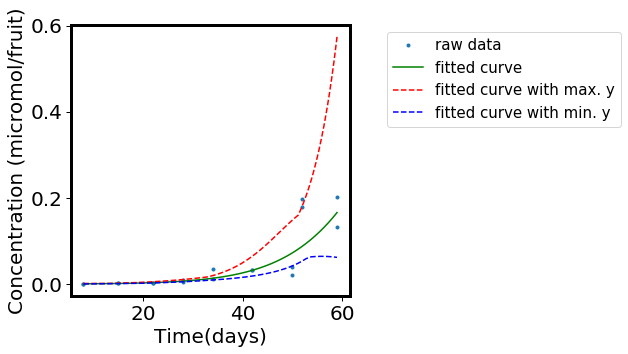

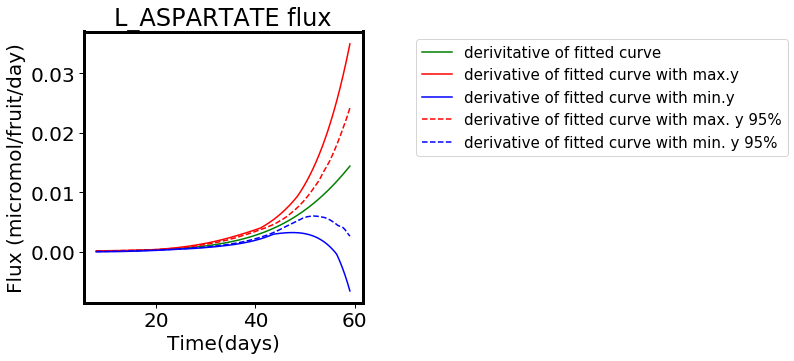

Processing GABA...


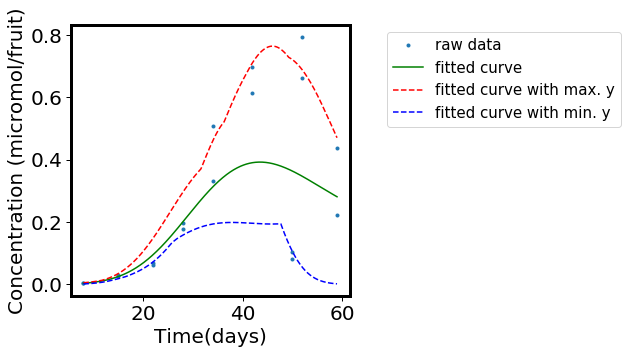

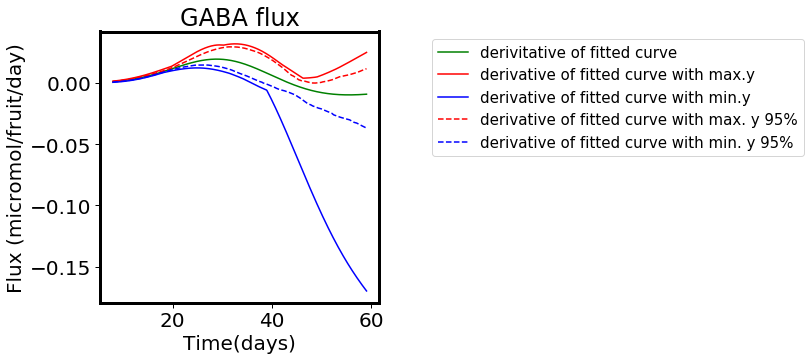

Processing GLT...


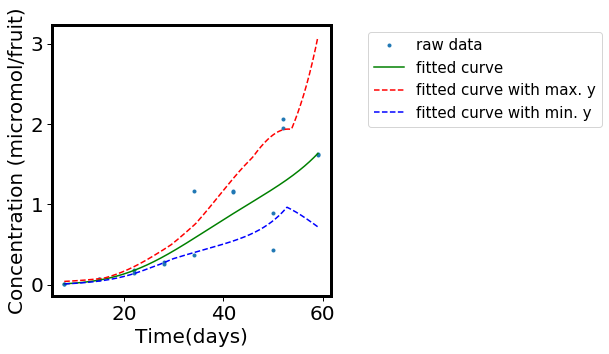

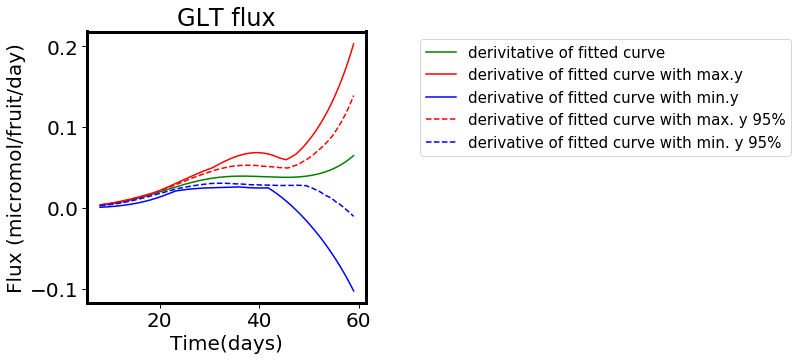

Processing GLN...


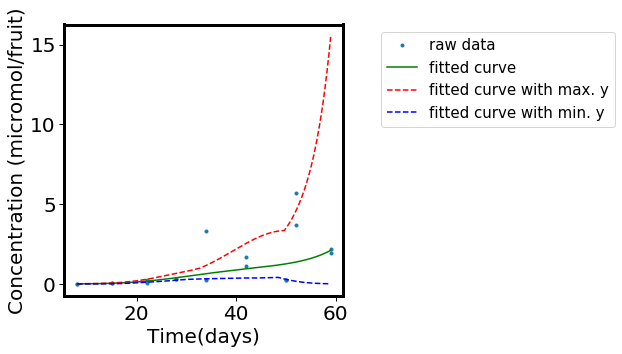

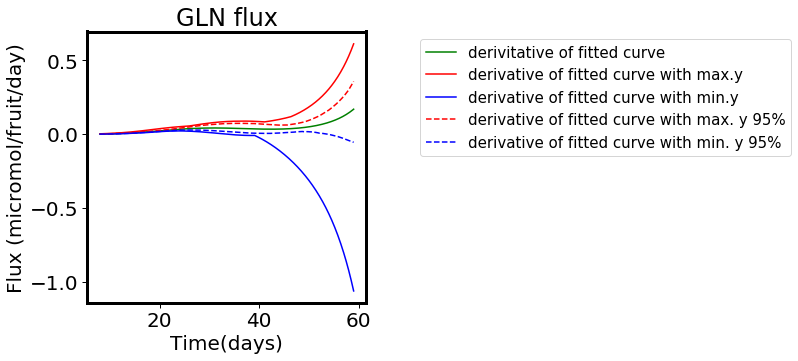

Processing GLY...


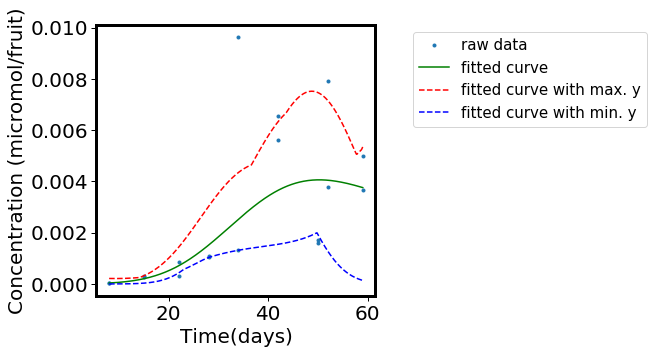

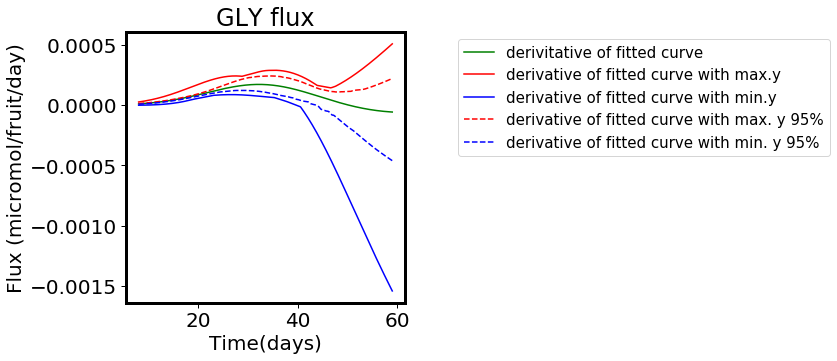

Processing ILE...


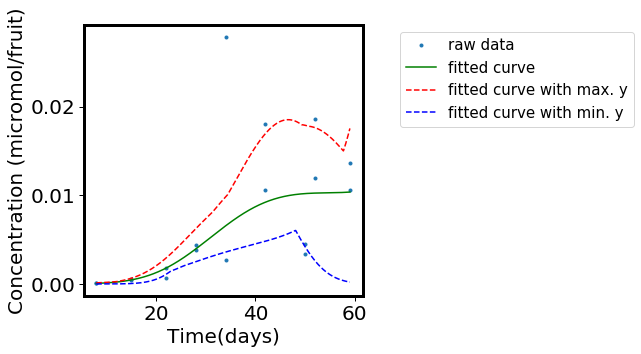

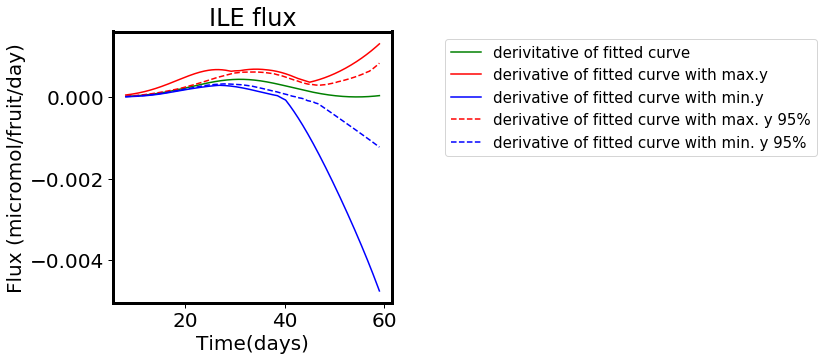

Processing LYS...


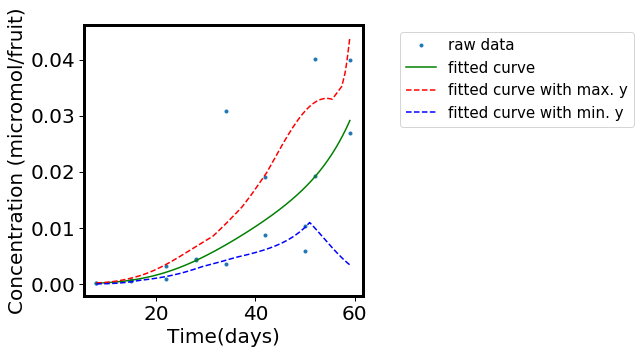

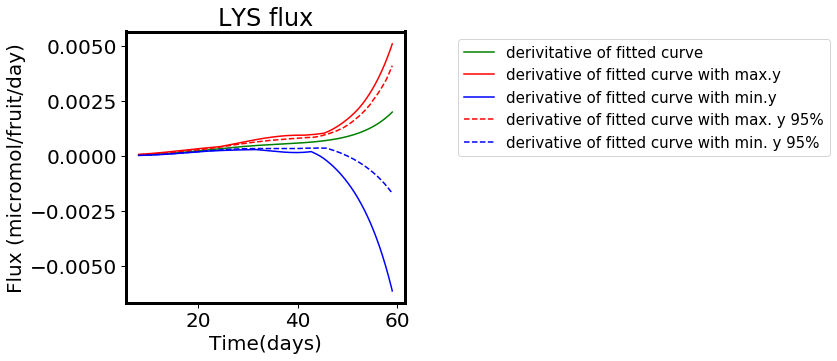

Processing MET...


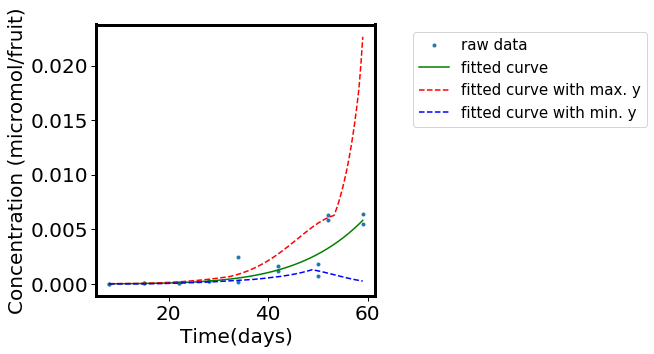

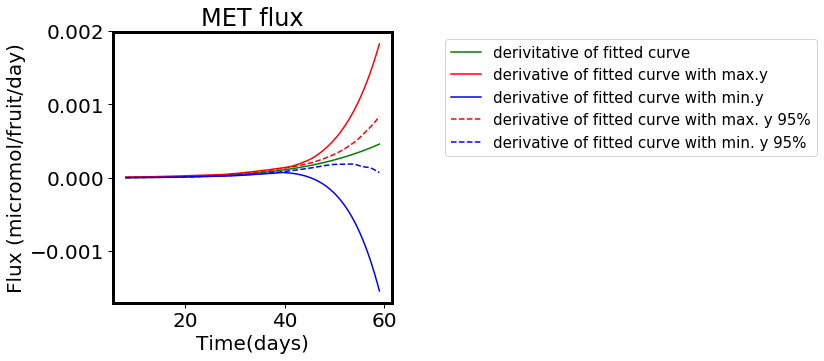

Processing PHE...


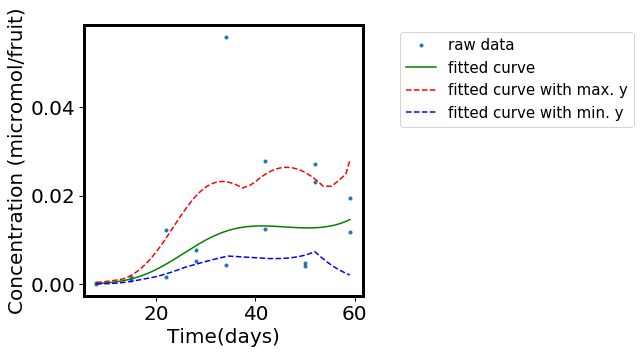

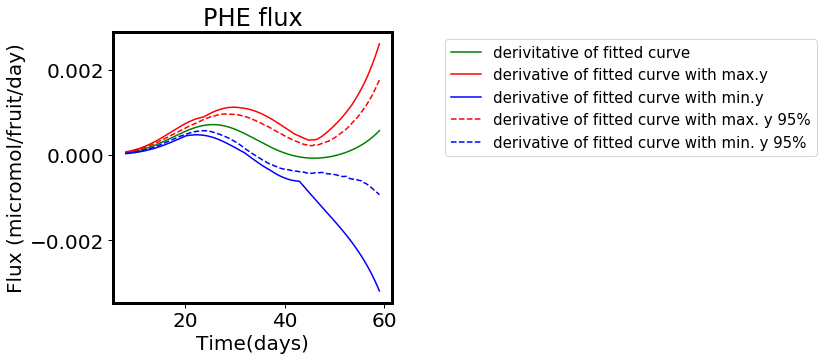

Processing PRO...


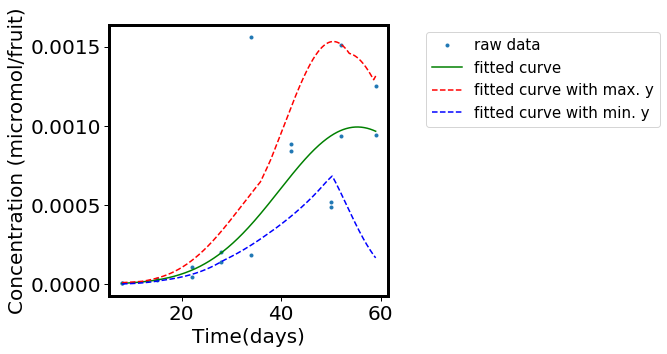

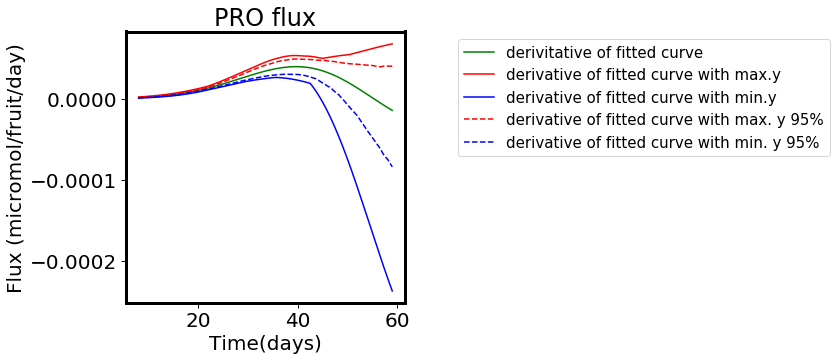

Processing SER...


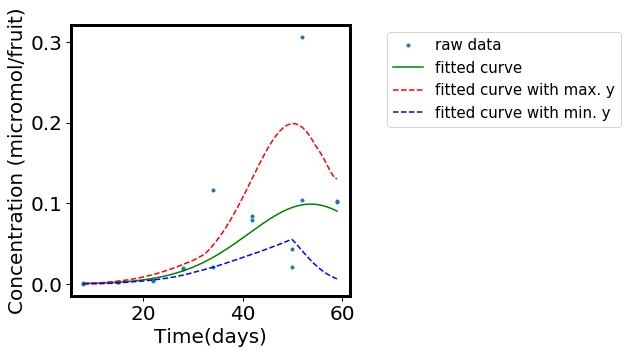

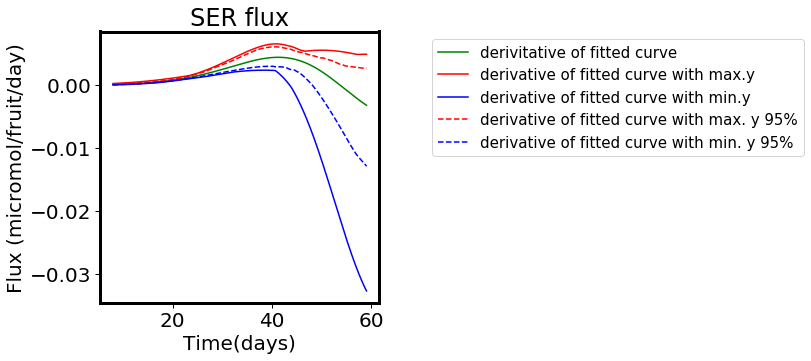

Processing THR...


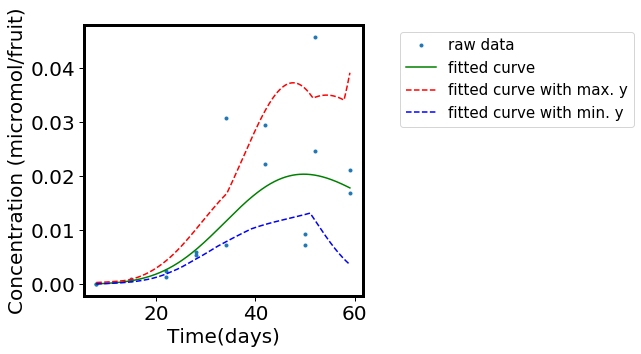

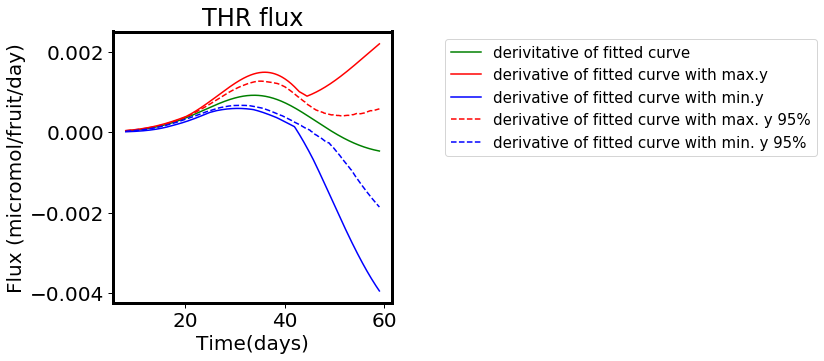

Processing TRP...


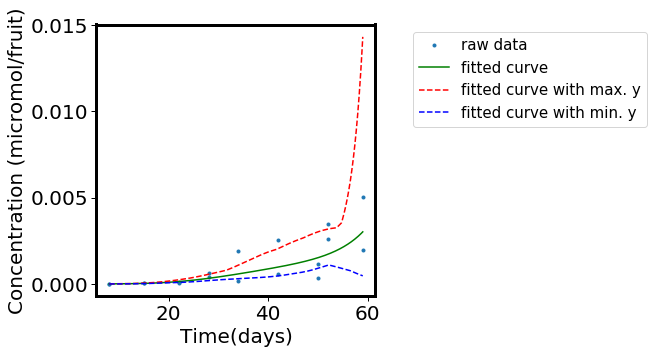

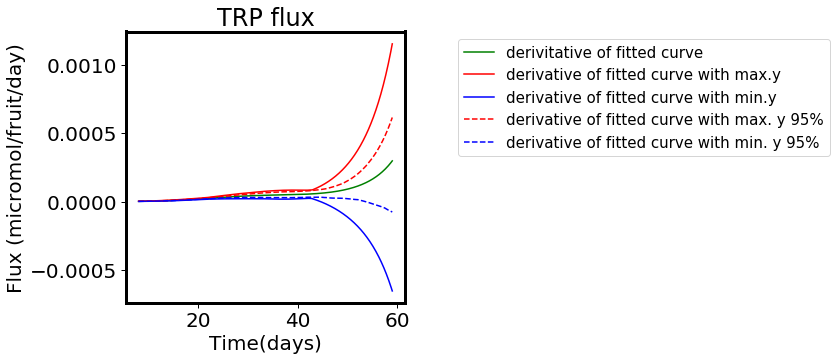

Processing TYR...


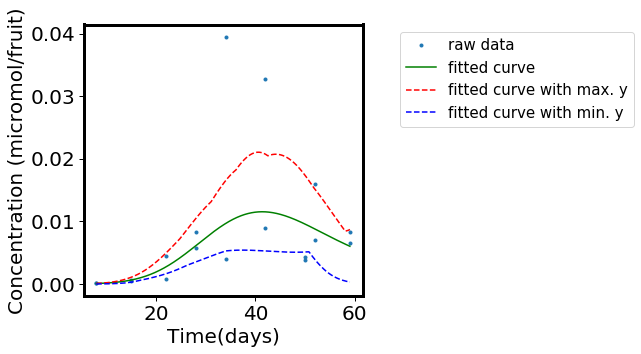

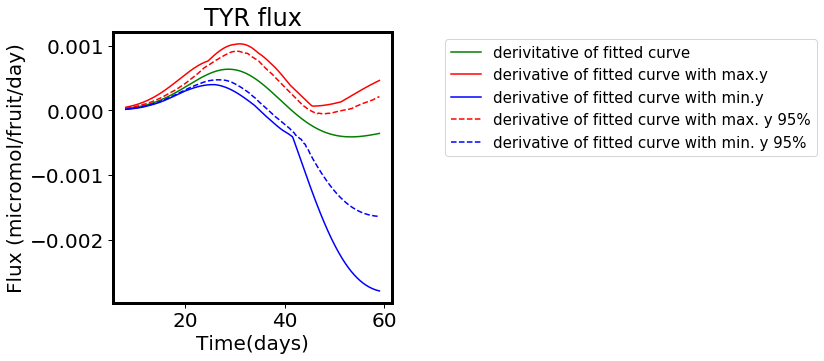

Processing VAL...


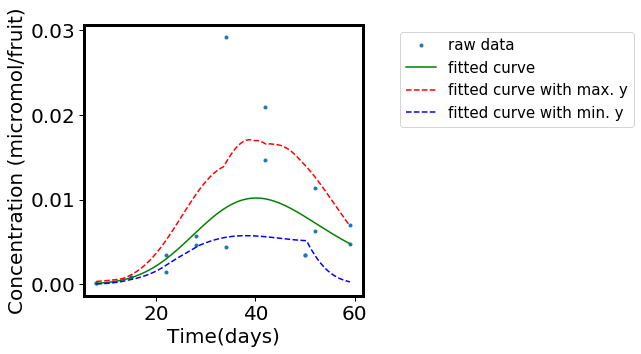

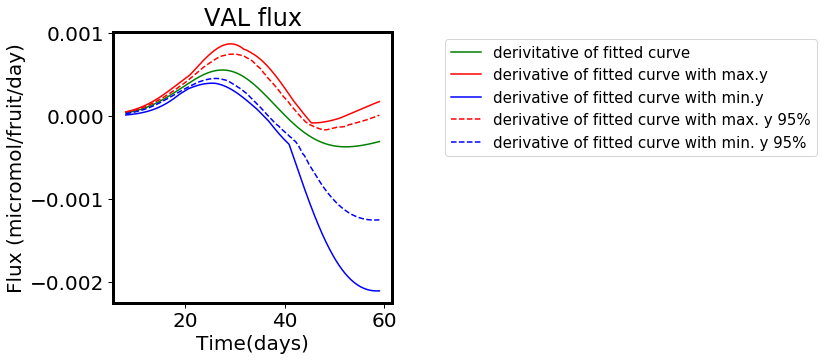

Processing FUM...


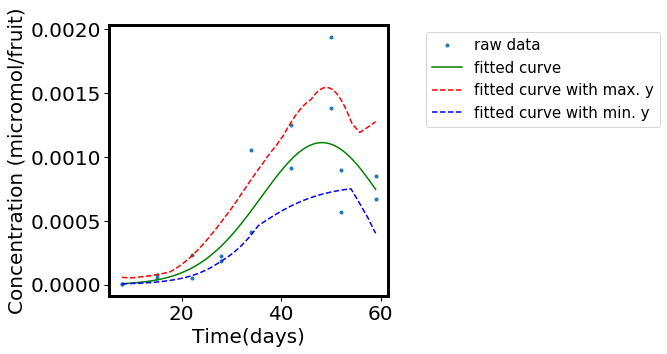

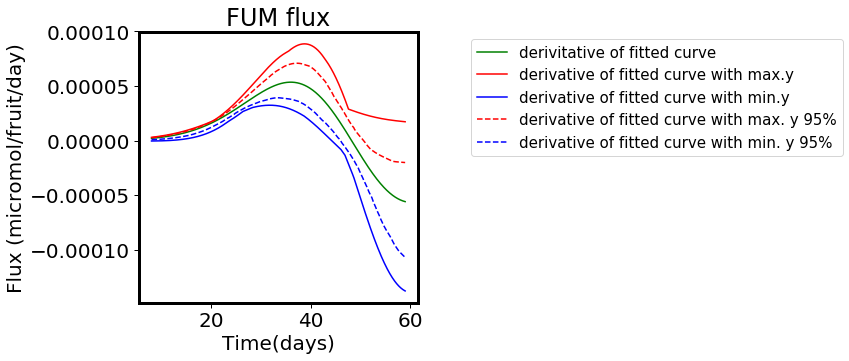

Processing STARCH...


In [32]:

#Retieve for soluble metabolites
import numpy as np
from studyFunctions import generateBoundsFromBiomass
#Day time points of interest
DAA = [26,27]

mets = ("GLC","FRU","SUC","MAL","CIT","L_ALPHA_ALANINE","ASN","L_ASPARTATE","GABA","GLT","GLN","GLY","ILE","LYS","MET","PHE","PRO","SER","THR","TRP","TYR","VAL","FUM")
#mets = ("GLC",)
dfile="Data/Data_OrganicSolutes.csv"
Nsampl= 1000
Ssampl= 0.80

conc = dict()
conc_min = dict()
conc_max = dict()
flux_max = dict()
flux_min = dict()

for met in mets:
  print "Processing "+met+"..."
  [conc[met],conc_max[met],conc_min[met],flux_max[met],flux_min[met]]=generateBoundsFromBiomass(datafile = dfile,met=met,Nsampling=Nsampl,DPA=DAA,show_plots=True,degree=3,Ssampling=Ssampl,start=8,stop=59)


mets = ("STARCH",)
dfile="Data/Data_Starch_Protein.csv"
Nsampl= 1000
Ssampl= 0.80

for met in mets:
  print "Processing "+met+"..."
  [conc[met],conc_max[met],conc_min[met],flux_max[met],flux_min[met]]=generateBoundsFromBiomass(datafile = dfile,met=met,Nsampling=Nsampl,DPA=DAA,show_plots=False,degree=3,Ssampling=Ssampl,start=8,stop=59)



In [33]:
import pandas as pd
df = pd.DataFrame(data={"mets":[],"amount":[]})
for met in conc.keys():
    df = df.append({"mets":met,"amount":conc[met][1]-conc[met][0]},ignore_index=True)
df

,amount,mets
0,0.000397,ILE
1,0.003990,SUC
2,0.039066,GLN
3,0.236108,GLC
4,0.000148,GLY
5,0.010235,CIT
6,0.000033,FUM
7,0.031649,GLT
8,0.001792,SER
9,0.000381,LYS


Maintenance costs estimated to be same as in dividing cells

In [34]:
Maint = 0.062 #mmol/mL

In [36]:


#import sbml file
expanding_model2 = io.sbml.create_cobra_model_from_sbml_file("Models/PlantCoreMetabolism_v1_2_3.xml")

#only glucose as nutrient
expanding_model2.reactions.get_by_id("GLC_tx").upper_bound = 1000
expanding_model2.reactions.get_by_id("GLC_tx").lower_bound = 0
expanding_model2.reactions.get_by_id("Sucrose_tx").upper_bound = 0
expanding_model2.reactions.get_by_id("Photon_tx").upper_bound = 0

#Setting up maintenance
met=Metabolite("ATPNAPDH_maintenance_constraint")
expanding_model2.reactions.get_by_id("ATPase_tx").add_metabolites({met:-1})
expanding_model2.reactions.get_by_id("NADPHoxc_tx").add_metabolites({met:3})
expanding_model2.reactions.get_by_id("NADPHoxp_tx").add_metabolites({met:3})
expanding_model2.reactions.get_by_id("NADPHoxm_tx").add_metabolites({met:3})
#maintenance from expanding cells
expanding_model2.reactions.get_by_id("ATPase_tx").lower_bound = Maint
expanding_model2.reactions.get_by_id("ATPase_tx").upper_bound = Maint

#Create a Protein_b metabolites
rxn = expanding_model2.reactions.get_by_id("Biomass_tx")
for met in ["Ca_b","K_b","Mg_b"]:
    met = expanding_model2.metabolites.get_by_id(met)
    coeff = rxn.metabolites.get(met)
    rxn.add_metabolites({met:-1*coeff})
met = Metabolite("Protein_b",name="Protein_biomass")
formula_dict = rxn.check_mass_balance()
met.formula = "".join([atom+str(formula_dict[atom]*-1) for atom in formula_dict.keys() if atom != "charge"])
met.charge = formula_dict["charge"]*-1
rxn.add_metabolites({met:1})


In [37]:

cellulose1 = celluloseLevels(Vcell1,Ncells)
cellulose2 = celluloseLevels(Vcell2,Ncells)
cellulose_acc = (cellulose2 - cellulose1)/10**6

lipid1 = phospholipidLevels(Vcell1,Ncells)
lipid2 = phospholipidLevels(Vcell2,Ncells)
lipid_acc = (lipid2 - lipid1)/10**6

ProteinConc = 2.5*(10**6)                             # unit = proteins/um3
ProteinConc = ProteinConc*(10**18)                    # unit = proteins/m3
Avagadro_N = 6*(10**23)
ProteinConc = ProteinConc*(1.0/Avagadro_N)            # unit = mol/m3
protein1 = estimateProteinContent(Vcell1,Ncells,ProteinConc)
protein2 = estimateProteinContent(Vcell2,Ncells,ProteinConc)
protein_acc = (protein2 - protein1)/10**6

#Add expanding cell biomass drain
rxn = Reaction("Biomass_expanding_cell")
rxn.add_metabolites({expanding_model2.metabolites.get_by_id("Cellulose_b"):-1*cellulose_acc})
rxn.add_metabolites({expanding_model2.metabolites.get_by_id("L_PHOSPHATIDATE_p"):-1*lipid_acc})
rxn.add_metabolites({expanding_model2.metabolites.get_by_id("Protein_b"):-1*protein_acc})
expanding_model2.add_reaction(rxn)
rxn.lower_bound = 1
rxn.upper_bound = 1

In [38]:
#Setting up osmotic constraints
soluteTranslate={"GABA":"4_AMINO_BUTYRATE","SUC":"SUCROSE","sCIT_b":"CIT","sMAL_b":"MAL",
                 "sSUC_b":"SUC","sFUM_b":"FUM","sASP_b":"L_ASPARTATE","sGLU_b":"GLT",
                 "sGLN_b":"GLN","sGABA_b":"4_AMINO_BUTYRATE","sALA_b":"L_ALPHA_ALANINE"}
VO = Metabolite("VO",name="vacuolar osmolytes")
VC = Metabolite("VC",name="vacuolar charge")
CO = Metabolite("CO",name="cytosolic osmolytes")
CC = Metabolite("CC",name="cytosolic charge")

rxn = Reaction("soluble_biomass")
expanding_model2.add_reaction(rxn)
for met2 in df["mets"]:
    if met2 == "STARCH":
        continue
    if met2 in soluteTranslate.keys():
        met = soluteTranslate[met2]
    else:
        met = met2
    METB = Metabolite(met+"_b")
    if met=="HIS":
        METV = expanding_model2.metabolites.get_by_id(met+"_v")
        rxn = Reaction(met+"_v_biomass")
        rxn.add_metabolites({METV:-1,VC:METV.charge,VO:1,METB:1})
        expanding_model2.add_reaction(rxn)
    elif met=="MAL":
        METV = expanding_model2.metabolites.get_by_id(met+"_v")
        aMETV = expanding_model2.metabolites.get_by_id("a"+met+"_v")
        charge = (METV.charge*0.7)+(aMETV.charge*0.3)
        rxn = Reaction(met+"_v_biomass")
        rxn.add_metabolites({METV:-0.7,aMETV:-0.3,VC:charge,VO:1,METB:1})
        expanding_model2.add_reaction(rxn)
    elif met=="CIT":
        METV = expanding_model2.metabolites.get_by_id(met+"_v")
        aMETV = expanding_model2.metabolites.get_by_id("a"+met+"_v")
        charge = (METV.charge*0.5)+(aMETV.charge*0.5)
        rxn = Reaction(met+"_v_biomass")
        rxn.add_metabolites({METV:-0.5,aMETV:-0.5,VC:charge,VO:1,METB:1})
        expanding_model2.add_reaction(rxn)
    elif met=="FUM":
        METV = expanding_model2.metabolites.get_by_id(met+"_v")
        aMETV = expanding_model2.metabolites.get_by_id("a"+met+"_v")
        charge = (METV.charge*0.92)+(aMETV.charge*0.08)
        rxn = Reaction(met+"_v_biomass")
        rxn.add_metabolites({METV:-0.92,aMETV:-0.08,VC:charge,VO:1,METB:1})
        expanding_model2.add_reaction(rxn)
    elif met=="SUC":
        print("Skipping SUC_v")
    else:
        METV = expanding_model2.metabolites.get_by_id(met+"_v")
        rxn = Reaction(met+"_v_biomass")
        rxn.add_metabolites({METV:-1,VC:METV.charge,VO:1,METB:1})
        expanding_model2.add_reaction(rxn)
    ##############
    METC = expanding_model2.metabolites.get_by_id(met+"_c")
    rxn = Reaction(met+"_c_biomass")
    rxn.add_metabolites({METC:-1,CC:METC.charge,CO:1,METB:1})
    expanding_model2.add_reaction(rxn)
    
    rxn = expanding_model2.reactions.get_by_id("soluble_biomass")
    rxn.add_metabolites({METB:-1*float(df["amount"][df["mets"]==met2])})

for met in ["NITRATE","AMMONIUM","MGII","KI","CAII"]:
    METB = Metabolite(met+"_b")
    METV = expanding_model2.metabolites.get_by_id(met+"_v")
    rxn = Reaction(met+"_v_biomass")
    rxn.add_metabolites({METV:-1,VC:METV.charge,VO:1,METB:1})
    expanding_model2.add_reaction(rxn)
    
    METC = expanding_model2.metabolites.get_by_id(met+"_c")
    rxn = Reaction(met+"_c_biomass")
    rxn.add_metabolites({METC:-1,CC:METC.charge,CO:1,METB:1})
    expanding_model2.add_reaction(rxn)
    
    rxn = Reaction(met+"_b_biomass")
    rxn.add_metabolites({METB:-1})
    expanding_model2.add_reaction(rxn)

rxn = Reaction("VacCytRatio")
WO = Metabolite("TotalSolute")
rxn.add_metabolites({CO:-1,VO:-1*(Vv/Vc),WO:1+(Vv/Vc)})
rxn.lower_bound = 0
rxn.upper_bound = 1000
expanding_model2.add_reaction(rxn)

C_cell = 275           #Almeida and Huber 1999; units = mOsmol/kg ~ mmol/L
C_cell = 275           #units = mol/m3

rxn = Reaction("TotalSoluteConstraint")
rxn.add_metabolites({WO:-1})
rxn.lower_bound = (C_cell*Vcell2*Ncells - C_cell*Vcell1*Ncells)
rxn.upper_bound = (C_cell*Vcell2*Ncells - C_cell*Vcell1*Ncells)
expanding_model2.add_reaction(rxn)

In [39]:
expanding_model2.reactions.get_by_id("Biomass_expanding_cell").objective_coefficient=0
expanding_model2.reactions.get_by_id("soluble_biomass").objective_coefficient=1
expanding_model2.reactions.get_by_id("GLC_tx").objective_coefficient=0

solution = flux_analysis.parsimonious.pfba(expanding_model2)
print("Minimal glucose uptake rate = "+str(expanding_model2.reactions.get_by_id("GLC_tx").x)+" mol/m3")
print("Minimal glucose uptake rate = "+str(expanding_model2.reactions.get_by_id("GLC_tx").x*expanding_model2.metabolites.get_by_id("GLC_c").formula_weight)+" g/L")


Minimal glucose uptake rate = 0.0322803229108 mol/m3
Minimal glucose uptake rate = 5.81548998068 g/L


In [40]:
from studyFunctions import writeSolutionFluxesToFile

writeSolutionFluxesToFile(solution,"ExpandingFluxes.csv",expanding_model2)

#### Data to generate flux map

In [41]:
mets = ["GLC_c","GLC_p","GLC_6_P_c","GLC_6_P_p","Cellulose_b","SUCROSE_c",
        "SUCROSE_v","FRU_c","FRU_v","FRUCTOSE_6P_c","GLYCEROL_3P_c","GAP_c",
        "GAP_p","G3P_c","G3P_p","PHOSPHO_ENOL_PYRUVATE_c","PHOSPHO_ENOL_PYRUVATE_p",
        "PYRUVATE_c","PYRUVATE_p","Protein_b"]
for met in mets:
    met = expanding_model2.metabolites.get_by_id(met)
    R = expanding_model2.reactions.get_by_id("GLC_ec")
    Cnum_std = expanding_model2.metabolites.get_by_id("GLC_c").elements["C"]
    Cnum = met.elements["C"]
    print "-----"
    print met.id
    for rxn in met.reactions:
        if round(rxn.x,5)==0:
            continue
        print rxn.id+"\t"+str(((rxn.x*rxn.metabolites.get(met)*Cnum)/(R.x*Cnum_std))*12)

-----
GLC_c
GLC_ec	12.0
GLC_PROTON_rev_vc	-3.61433377665
GLUCOKIN_RXN_c	-8.38566622335
-----
GLC_p
-----
GLC_6_P_c
PGLUCISOM_RXN_c	-5.42163790309
GLU6PDEHYDROG_RXN_c	-1.94423339819
GLUCOKIN_RXN_c	8.38566622335
PHOSPHOGLUCMUT_RXN_c	-1.01979492207
-----
GLC_6_P_p
PGLUCISOM_RXN_p	0.485163164227
GLU6PDEHYDROG_RXN_p	-0.485163164227
-----
Cellulose_b
Cellulose_biomass	0.958709097766
Biomass_expanding_cell	-0.958709097766
-----
SUCROSE_c
SUCROSE_c_biomass	-0.122171648608
SUCROSE_SYNTHASE_RXN_c	-6.56219138046
SUCROSE_PHOSPHATASE_RXN_c	6.68436302907
-----
SUCROSE_v
-----
FRU_c
FRU_PROTON_rev_vc	-3.28109569023
SUCROSE_SYNTHASE_RXN_c	3.28109569023
-----
FRU_v
FRU_PROTON_rev_vc	3.28109569023
FRU_v_biomass	-3.28109569023
-----
FRUCTOSE_6P_c
PGLUCISOM_RXN_c	5.42163790309
2_PERIOD_7_PERIOD_1_PERIOD_90_RXN_c	-1.29128391824
SUCROSE_PHOSPHATE_SYNTHASE_RXN_c	-3.34218151453
6PFRUCTPHOS_RXN_c	-0.788172470322
-----
GLYCEROL_3P_c
GLYC3PDEHYDROGBIOSYN_RXN_c	0.0273637739338
GLYCEROL_3P_pc	-0.0273637739338
----

In [42]:
R = expanding_model2.reactions.get_by_id("GLC_ec")
Cnum_std = expanding_model2.metabolites.get_by_id("GLC_c").elements["C"]
for rxn in expanding_model2.reactions.query("_c_biomass"):    
    met = list(set(rxn.products) - set([expanding_model2.metabolites.get_by_id("CC"),
                                        expanding_model2.metabolites.get_by_id("VC"),
                                        expanding_model2.metabolites.get_by_id("VO"),
                                        expanding_model2.metabolites.get_by_id("CO")]))[0]
    
    if "C" in met.elements.keys():
        Cnum = met.elements["C"]
    else:
        formula_dict = rxn.check_mass_balance()
        formula = "".join([atom+str(formula_dict[atom]*-1) for atom in formula_dict.keys() if atom != "charge"])
        if "C" in formula and "Ca" not in formula:
            met.formula= formula
            Cnum = met.elements["C"]
        else:
            Cnum = 1
    print "-----"
    print met.id
    for rxn in met.reactions:
        if round(rxn.x,5)==0:
            continue
        print rxn.id+"\t"+str(((rxn.x*rxn.metabolites.get(met)*Cnum)/(R.x*Cnum_std))*12)

-----
ILE_b
ILE_v_biomass	0.00607465758398
soluble_biomass	-0.00607465758398
-----
SUCROSE_b
SUCROSE_c_biomass	0.122171648608
soluble_biomass	-0.122171648608
-----
GLN_b
GLN_v_biomass	0.498352977311
soluble_biomass	-0.498352977311
-----
GLC_b
GLC_v_biomass	3.61433377665
soluble_biomass	-3.61433377665
-----
GLY_b
GLY_v_biomass	0.000753412298886
soluble_biomass	-0.000753412298886
-----
CIT_b
CIT_v_biomass	0.156678002829
soluble_biomass	-0.156678002829
-----
FUM_b
soluble_biomass	-0.000341432559625
-----
GLT_b
GLT_c_biomass	0.403731328715
soluble_biomass	-0.403731328715
-----
SER_b
SER_v_biomass	0.0137125316478
soluble_biomass	-0.0137125316478
-----
LYS_b
LYS_v_biomass	0.00583051481247
soluble_biomass	-0.00583051481247
-----
PRO_b
soluble_biomass	-0.000270602996683
-----
L_ASPARTATE_b
L_ASPARTATE_c_biomass	0.00680919054472
soluble_biomass	-0.00680919054472
-----
ASN_b
ASN_c_biomass	0.00645935174134
soluble_biomass	-0.00645935174134
-----
L_ALPHA_ALANINE_b
soluble_biomass	-0.00085691733589

### When organic content maximized and SOF is minimized

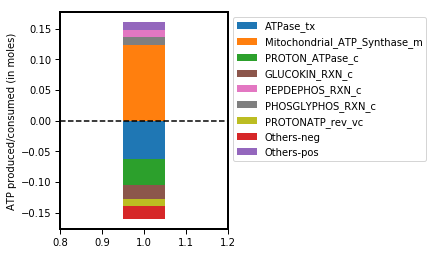

In [43]:
from studyFunctions import writeSolutionFluxesToFile

generateATPbudget(expanding_model2,solution.fluxes,outfile="/home/sanu/ATPbudget_expanding26_max.csv",
                  show_plot=True,percentage=False,day_or_night_tag="",save_plot_to="temp.png",colourDict={})

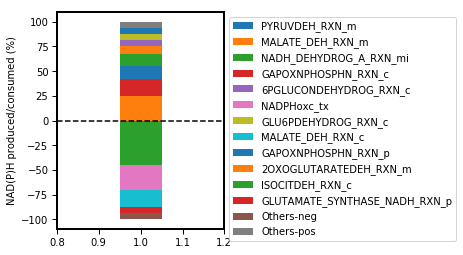

In [44]:
from studyFunctions import writeSolutionFluxesToFile

generateNADHNADPHbudget(expanding_model2,solution.fluxes,outfile="/home/sanu/NADPHbudget_expanding26_max",
                        show_plot=True,percentage=True,day_or_night_tag="",save_plot_to="temp.png",colourDict={})

### When SOF is minimized

In [45]:
model = expanding_model2.copy()
model.reactions.get_by_id("Biomass_expanding_cell").objective_coefficient=1
model.reactions.get_by_id("soluble_biomass").objective_coefficient=0
model.reactions.get_by_id("GLC_tx").objective_coefficient=0

solution = flux_analysis.parsimonious.pfba(model)
print("Minimal glucose uptake rate = "+str(model.reactions.get_by_id("GLC_tx").x)+" mol/m3")
print("Minimal glucose uptake rate = "+str(model.reactions.get_by_id("GLC_tx").x*expanding_model2.metabolites.get_by_id("GLC_c").formula_weight)+" g/L")



Minimal glucose uptake rate = 0.0089536030658 mol/m3
Minimal glucose uptake rate = 1.61304423949 g/L


In [46]:
from studyFunctions import writeSolutionFluxesToFile

writeSolutionFluxesToFile(solution,"ExpandingFluxes_minSOF.csv",model)

#### Data to generate flux map

In [47]:
mets = ["GLC_c","GLC_p","GLC_6_P_c","GLC_6_P_p","Cellulose_b","SUCROSE_c",
        "SUCROSE_v","FRU_c","FRU_v","FRUCTOSE_6P_c","GLYCEROL_3P_c","GAP_c",
        "GAP_p","G3P_c","G3P_p","PHOSPHO_ENOL_PYRUVATE_c","PHOSPHO_ENOL_PYRUVATE_p",
        "PYRUVATE_c","PYRUVATE_p","Protein_b"]
for met in mets:
    met = model.metabolites.get_by_id(met)
    R = model.reactions.get_by_id("GLC_ec")
    Cnum_std = model.metabolites.get_by_id("GLC_c").elements["C"]
    Cnum = met.elements["C"]
    print "-----"
    print met.id
    for rxn in met.reactions:
        if round(rxn.x,5)==0:
            continue
        print rxn.id+"\t"+str(((rxn.x*rxn.metabolites.get(met)*Cnum)/(R.x*Cnum_std))*12)

-----
GLC_c
GLC_ec	12.0
GLUCOKIN_RXN_c	-12.0
-----
GLC_p
-----
GLC_6_P_c
PGLUCISOM_RXN_c	-4.40028740238
G6P_Pi_pc	3.23277409571
PHOSPHOGLUCMUT_RXN_c	-3.4564229647
GLU6PDEHYDROG_RXN_c	-7.37606372863
GLUCOKIN_RXN_c	12.0
-----
GLC_6_P_p
PGLUCISOM_RXN_p	7.01745486803
GLU6PDEHYDROG_RXN_p	-3.78468077232
G6P_Pi_pc	-3.23277409571
-----
Cellulose_b
Biomass_expanding_cell	-3.4564229647
Cellulose_biomass	3.4564229647
-----
SUCROSE_c
-----
SUCROSE_v
-----
FRU_c
-----
FRU_v
-----
FRUCTOSE_6P_c
2_PERIOD_7_PERIOD_1_PERIOD_90_RXN_c	-4.40028740238
PGLUCISOM_RXN_c	4.40028740238
-----
GLYCEROL_3P_c
GLYC3PDEHYDROGBIOSYN_RXN_c	0.0986543017544
GLYCEROL_3P_pc	-0.0986543017544
-----
GAP_c
GAPOXNPHOSPHN_RXN_c	-5.0253214251
TRIOSEPISOMERIZATION_RXN_c	2.10148939944
F16ALDOLASE_RXN_c	2.20014370119
GAP_Pi_pc	0.723688324473
-----
GAP_p
F16ALDOLASE_RXN_p	0.179304430303
GAP_Pi_pc	-0.723688324473
2TRANSKETO_RXN_p	1.8175522307
GAPOXNPHOSPHN_RXN_p	-1.45247276683
TRANSALDOL_RXN_p	-1.87047963362
1TRANSKETO_RXN_p	1.8704796

In [48]:
R = model.reactions.get_by_id("GLC_ec")
Cnum_std = model.metabolites.get_by_id("GLC_c").elements["C"]
for rxn in model.reactions.query("_c_biomass"):    
    met = list(set(rxn.products) - set([model.metabolites.get_by_id("CC"),
                                        model.metabolites.get_by_id("VC"),
                                        model.metabolites.get_by_id("VO"),
                                        model.metabolites.get_by_id("CO")]))[0]
    
    if "C" in met.elements.keys():
        Cnum = met.elements["C"]
    else:
        formula_dict = rxn.check_mass_balance()
        formula = "".join([atom+str(formula_dict[atom]*-1) for atom in formula_dict.keys() if atom != "charge"])
        if "C" in formula and "Ca" not in formula:
            met.formula= formula
            Cnum = met.elements["C"]
        else:
            Cnum = 1
    print "-----"
    print met.id
    for rxn in met.reactions:
        if round(rxn.x,5)==0:
            continue
        print rxn.id+"\t"+str(((rxn.x*rxn.metabolites.get(met)*Cnum)/(R.x*Cnum_std))*12)

-----
ILE_b
-----
SUCROSE_b
-----
GLN_b
-----
GLC_b
-----
GLY_b
-----
CIT_b
-----
FUM_b
-----
GLT_b
-----
SER_b
-----
LYS_b
-----
PRO_b
-----
L_ASPARTATE_b
-----
ASN_b
-----
L_ALPHA_ALANINE_b
-----
VAL_b
-----
THR_b
-----
FRU_b
-----
TRP_b
-----
PHE_b
-----
MET_b
-----
MAL_b
-----
TYR_b
-----
4_AMINO_BUTYRATE_b
-----
NITRATE_b
NITRATE_v_biomass	2.60121527718
NITRATE_c_biomass	0.272221869871
NITRATE_b_biomass	-2.87343714705
-----
AMMONIUM_b
AMMONIUM_v_biomass	2.60121527718
AMMONIUM_c_biomass	0.272221869871
AMMONIUM_b_biomass	-2.87343714705
-----
MGII_b
-----
KI_b
-----
CAII_b


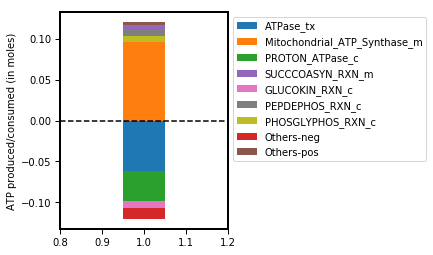

In [49]:
from studyFunctions import generateATPbudget

generateATPbudget(expanding_model2,solution.fluxes,outfile="ATPbudget_expandingCells_minSOF.csv",
                  show_plot=True,percentage=False,day_or_night_tag="",save_plot_to="temp.png",colourDict={})

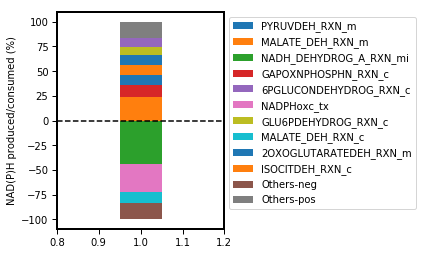

In [50]:
from studyFunctions import generateATPbudget

generateNADHNADPHbudget(expanding_model2,solution.fluxes,outfile="NADPHbudget_expandingCells_minSOF",
                        show_plot=True,percentage=True,day_or_night_tag="",save_plot_to="temp.png",colourDict={})

### Estiamting ATP cost of protein, lipid and cellulose biosynthesis

In [51]:
temp_model3 = expanding_model2.copy()
temp_model3.reactions.get_by_id("AraCore_Biomass_tx").lower_bound = 0
temp_model3.reactions.get_by_id("AraCore_Biomass_tx").upper_bound = 0
temp_model3.reactions.get_by_id("Biomass_expanding_cell").upper_bound = 0
temp_model3.reactions.get_by_id("Biomass_expanding_cell").lower_bound = 0
temp_model3.reactions.get_by_id("Biomass_expanding_cell").upper_bound = 0
temp_model3.reactions.get_by_id("TotalSoluteConstraint").lower_bound = 0
temp_model3.reactions.get_by_id("TotalSoluteConstraint").upper_bound = 0
rxn =Reaction("tempSINK")
rxn.add_metabolites({temp_model3.metabolites.get_by_id("Protein_b"):-1})
rxn.lower_bound = expanding_model2.reactions.get_by_id("Biomass_tx").x
rxn.upper_bound = expanding_model2.reactions.get_by_id("Biomass_tx").x
temp_model3.add_reaction(rxn)
temp_model3.reactions.get_by_id("ATPase_tx").add_metabolites({temp_model3.metabolites.get_by_id("ATPNAPDH_maintenance_constraint"):1})
temp_model3.reactions.get_by_id("ATPase_tx").lower_bound = -1000
temp_model3.reactions.get_by_id("ATPase_tx").upper_bound = 1000
temp_model3.reactions.get_by_id("Biomass_expanding_cell").objective_coefficient = 0
temp_model3.reactions.get_by_id("tempSINK").objective_coefficient = 1
temp_solution = flux_analysis.parsimonious.pfba(temp_model3)
print("protein")
temp_model3.reactions.get_by_id("ATPase_tx").x

protein


-0.0069998612592711415

In [52]:
temp_model3 = expanding_model2.copy()
temp_model3.reactions.get_by_id("AraCore_Biomass_tx").lower_bound = 0
temp_model3.reactions.get_by_id("AraCore_Biomass_tx").upper_bound = 0
temp_model3.reactions.get_by_id("Biomass_expanding_cell").lower_bound = 0
temp_model3.reactions.get_by_id("Biomass_expanding_cell").upper_bound = 0
temp_model3.reactions.get_by_id("TotalSoluteConstraint").lower_bound = 0
temp_model3.reactions.get_by_id("TotalSoluteConstraint").upper_bound = 0
rxn =Reaction("tempSINK")
rxn.add_metabolites({temp_model3.metabolites.get_by_id("L_PHOSPHATIDATE_p"):-1})
rxn.lower_bound = expanding_model2.reactions.get_by_id("1_ACYLGLYCEROL_3_P_ACYLTRANSFER_RXN_p").x
rxn.upper_bound = expanding_model2.reactions.get_by_id("1_ACYLGLYCEROL_3_P_ACYLTRANSFER_RXN_p").x
temp_model3.add_reaction(rxn)
temp_model3.reactions.get_by_id("ATPase_tx").add_metabolites({temp_model3.metabolites.get_by_id("ATPNAPDH_maintenance_constraint"):1})
temp_model3.reactions.get_by_id("ATPase_tx").lower_bound = -1000
temp_model3.reactions.get_by_id("ATPase_tx").upper_bound = 1000
temp_model3.reactions.get_by_id("Biomass_expanding_cell").objective_coefficient = 0
temp_model3.reactions.get_by_id("tempSINK").objective_coefficient = 1
temp_solution = flux_analysis.parsimonious.pfba(temp_model3)
print("lipid")
temp_model3.reactions.get_by_id("ATPase_tx").x

lipid


-0.004306143360881786

In [53]:
temp_model3 = expanding_model2.copy()
temp_model3.reactions.get_by_id("AraCore_Biomass_tx").lower_bound = 0
temp_model3.reactions.get_by_id("AraCore_Biomass_tx").upper_bound = 0
temp_model3.reactions.get_by_id("Biomass_expanding_cell").lower_bound = 0
temp_model3.reactions.get_by_id("Biomass_expanding_cell").upper_bound = 0
temp_model3.reactions.get_by_id("TotalSoluteConstraint").lower_bound = 0
temp_model3.reactions.get_by_id("TotalSoluteConstraint").upper_bound = 0
rxn =Reaction("tempSINK")
rxn.add_metabolites({temp_model3.metabolites.get_by_id("Cellulose_b"):-1})
rxn.lower_bound = abs(expanding_model2.reactions.get_by_id("Cellulose_biomass").x)
rxn.upper_bound = abs(expanding_model2.reactions.get_by_id("Cellulose_biomass").x)
temp_model3.add_reaction(rxn)
temp_model3.reactions.get_by_id("ATPase_tx").add_metabolites({temp_model3.metabolites.get_by_id("ATPNAPDH_maintenance_constraint"):1})
temp_model3.reactions.get_by_id("ATPase_tx").lower_bound = -1000
temp_model3.reactions.get_by_id("ATPase_tx").upper_bound = 1000
temp_model3.reactions.get_by_id("Biomass_expanding_cell").objective_coefficient = 0
temp_model3.reactions.get_by_id("tempSINK").objective_coefficient = 1
temp_solution = flux_analysis.parsimonious.pfba(temp_model3)
print("cellulose")
temp_model3.reactions.get_by_id("ATPase_tx").x

cellulose


-0.007736859813348957